In [97]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [98]:
# File path to the Excel file
file_path = "data.xlsx"  # Replace with your actual file path

# Load the Excel file into a dictionary of DataFrames
# Read all sheets into a dictionary of DataFrames
excel_data = pd.read_excel(os.path.join(os.getcwd(), "data", file_path), sheet_name=None)
print("Excel file successfully loaded!")

# Access specific sheets by name
df_jan_summary = excel_data.get("jan_summary", pd.DataFrame())
df_oct_summary = excel_data.get("oct_summary", pd.DataFrame())

data = pd.concat([df_jan_summary, df_oct_summary], ignore_index=True)

data = data.dropna()

Excel file successfully loaded!


In [99]:
# Ensure non-numeric columns are excluded
numeric_columns = data.select_dtypes(include=["number"])

# Calculate short-term and long-term trends
data["Short_MA"] = numeric_columns["Average_Return"].rolling(window=3).mean()
data["Long_MA"] = numeric_columns["Average_Return"].rolling(window=10).mean()

# Identify trend changes
data["Trend_Change"] = (data["Short_MA"] > data["Long_MA"]).astype(int)

# Correlation with trend changes
# trend_corr = numeric_columns.corr()["Trend_Change"].sort_values(ascending=False)

# Forward fill and backward fill Short_MA and Long_MA without inplace
data["Short_MA"] = data["Short_MA"].ffill().bfill()
data["Long_MA"] = data["Long_MA"].ffill().bfill()

In [100]:
data

,anonymous signal,Reversal_Frequency,Average_Return,Max_Positive_Return,Max_Negative_Return,Forward_1D_Return_Avg,Forward_2D_Return_Avg,Forward_3D_Return_Avg,Forward_4D_Return_Avg,Forward_5D_Return_Avg,Two_Day_Reversal_Return_Avg,Ticker,Short_MA,Long_MA,Trend_Change
13,45,1,-5.150000,-5.15,-5.15,-0.799091,1.020909,2.888182,4.854545,6.222727,-0.360,AMD,1.351111,5.312896,0
14,46,1,1.780000,8.46,-4.90,0.423750,1.887500,3.858750,6.262500,7.085000,-0.320,AMD,1.351111,5.312896,0
15,47,2,7.423333,8.39,5.51,3.408333,5.505000,5.818333,7.820000,9.175000,0.835,AMD,1.351111,5.312896,0
17,49,1,8.175000,14.02,1.40,1.923043,3.685652,5.322727,7.403182,8.392727,-3.850,AMD,5.792778,5.312896,0
18,50,3,7.690000,10.83,1.81,1.322857,2.654286,4.132308,6.865385,8.374615,-2.270,AMD,7.762778,5.312896,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,91,2,4.358500,6.17,0.98,0.860000,1.760000,3.892222,4.470000,4.823889,1.255,ORCL,4.127497,3.901112,1
1640,93,1,4.819412,5.82,1.19,0.384706,2.291176,4.607647,4.800000,4.226471,2.070,ORCL,4.331885,4.015037,1
1641,94,2,4.163750,5.57,1.16,1.370000,2.764000,4.353333,4.876667,4.698667,0.985,ORCL,4.447221,4.048996,1
1643,96,1,4.475294,5.66,3.40,1.373529,3.077059,4.392941,4.950588,4.664118,0.420,ORCL,4.486152,4.094146,1


In [101]:
columns_to_use = ['anonymous signal', 'Reversal_Frequency', 'Average_Return', 'Max_Positive_Return',
                  'Max_Negative_Return', 'Forward_1D_Return_Avg', 'Forward_2D_Return_Avg', 
                  'Forward_3D_Return_Avg', 'Forward_4D_Return_Avg', 'Forward_5D_Return_Avg', 'Two_Day_Reversal_Return_Avg', 'Short_MA', 'Long_MA']

data = data[columns_to_use].dropna()  # 删除缺失值

targets = ['Forward_1D_Return_Avg', 'Forward_2D_Return_Avg', 
           'Forward_3D_Return_Avg', 'Forward_4D_Return_Avg','Forward_5D_Return_Avg']

signal_columns = ['anonymous signal', 'Average_Return', 'Reversal_Frequency',
                  'Max_Positive_Return', 'Max_Negative_Return', 'Two_Day_Reversal_Return_Avg']



In [102]:
signal_importance = {}

for target in targets:
    print(f"\n--- Processing Model for {target} ---")
    X = data[signal_columns]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    signal_importance[target] = dict(zip(signal_columns, lasso.coef_))
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error for {target}: {mse:.4f}")
    print(f"R-squared Score for {target}: {r2:.4f}")
    
    print("Lasso Coefficients:")
    for signal, coef in signal_importance[target].items(): print(f"{signal}: {coef:.4f}")

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)
        


--- Processing Model for Forward_1D_Return_Avg ---
Mean Squared Error for Forward_1D_Return_Avg: 6.0468
R-squared Score for Forward_1D_Return_Avg: 0.2960
Lasso Coefficients:
anonymous signal: -0.0093
Average_Return: -0.0821
Reversal_Frequency: -0.0031
Max_Positive_Return: 0.1071
Max_Negative_Return: 0.1157
Two_Day_Reversal_Return_Avg: -0.6561
                       Feature        VIF
0             anonymous signal   3.222535
1               Average_Return  10.235574
2           Reversal_Frequency   2.274026
3          Max_Positive_Return  12.703321
4          Max_Negative_Return   6.724016
5  Two_Day_Reversal_Return_Avg   1.269885

--- Processing Model for Forward_2D_Return_Avg ---
Mean Squared Error for Forward_2D_Return_Avg: 17.7738
R-squared Score for Forward_2D_Return_Avg: 0.3675
Lasso Coefficients:
anonymous signal: -0.0150
Average_Return: -0.1611
Reversal_Frequency: -0.0087
Max_Positive_Return: 0.2169
Max_Negative_Return: 0.2264
Two_Day_Reversal_Return_Avg: -1.1735
             


--- Signal Importance Analysis ---

Target: Forward_1D_Return_Avg
anonymous signal: -0.0093
Average_Return: -0.0821
Reversal_Frequency: -0.0031
Max_Positive_Return: 0.1071
Max_Negative_Return: 0.1157
Two_Day_Reversal_Return_Avg: -0.6561

Target: Forward_2D_Return_Avg
anonymous signal: -0.0150
Average_Return: -0.1611
Reversal_Frequency: -0.0087
Max_Positive_Return: 0.2169
Max_Negative_Return: 0.2264
Two_Day_Reversal_Return_Avg: -1.1735

Target: Forward_3D_Return_Avg
anonymous signal: -0.0269
Average_Return: -0.1844
Reversal_Frequency: -0.0131
Max_Positive_Return: 0.3078
Max_Negative_Return: 0.3172
Two_Day_Reversal_Return_Avg: -1.4643

Target: Forward_4D_Return_Avg
anonymous signal: -0.0356
Average_Return: -0.2785
Reversal_Frequency: -0.0138
Max_Positive_Return: 0.4312
Max_Negative_Return: 0.4438
Two_Day_Reversal_Return_Avg: -1.7994

Target: Forward_5D_Return_Avg
anonymous signal: -0.0476
Average_Return: -0.3861
Reversal_Frequency: -0.0163
Max_Positive_Return: 0.5351
Max_Negative_Return

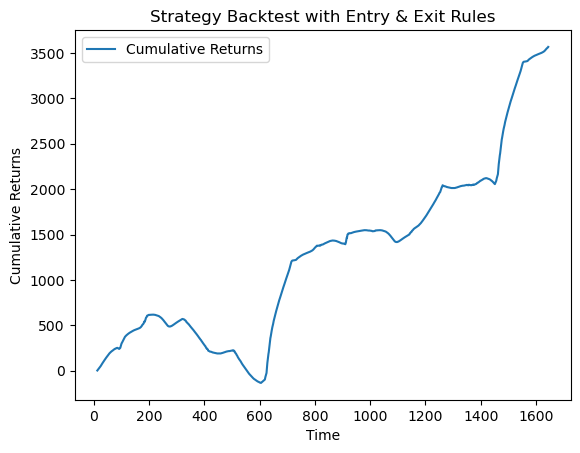

In [103]:

print("\n--- Signal Importance Analysis ---")
for target, importance in signal_importance.items():
    print(f"\nTarget: {target}")
    for signal, coef in importance.items():
        print(f"{signal}: {coef:.4f}")

def generate_trading_signals(data, signal_col, threshold):

    data['Signal_Buy'] = np.where(data[signal_col] > threshold, 1, 0)
    data['Signal_Sell'] = np.where(data[signal_col] < -threshold, -1, 0)
    return data

def backtest_strategy(data, target_return_col):
  
    data['Strategy_Return'] = np.where(data['Signal_Buy'] == 1, data[target_return_col], 0)
    
    # 计算累计收益
    data['Cumulative_Returns'] = data['Strategy_Return'].cumsum()

    # 计算命中率（Win Rate）
    total_trades = data['Signal_Buy'].sum() + data['Signal_Sell'].sum()
    profitable_trades = data[data['Strategy_Return'] > 0]['Strategy_Return'].count()
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0
    
    # 计算最大回撤（Maximum Drawdown）
    peak = data['Cumulative_Returns'].expanding(min_periods=1).max()
    drawdown = (data['Cumulative_Returns'] - peak) / peak
    max_drawdown = drawdown.min()

    return data['Cumulative_Returns'], win_rate, max_drawdown

threshold = 0.5  
data_with_signals = generate_trading_signals(data, 'anonymous signal', threshold)

cumulative_returns, win_rate, max_drawdown = backtest_strategy(data_with_signals, 'Forward_3D_Return_Avg')

print(f"---Hit Ratio (Win Rate): {win_rate:.4f}")
print(f"---Maximum Drawdown: {max_drawdown:.4f}")

plt.plot(cumulative_returns, label='Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Strategy Backtest with Entry & Exit Rules')
plt.legend()
plt.show()